# **UNET PET SEGMENTATION**

# **Import library**

In [ ]:
!pip install tensorflow_datasets==4.9.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# **DATA**
Using dataset: "oxford_iiit_pet" from TFDS.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJIX4UP/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJIX4UP/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Thông tin bộ dữ liệu. Các tập train và test đã được tích hợp sẵn.

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpwt5b3ij5tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

# **Data preprocessing**

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="bilinear")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Randomly flip image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
print(train_dataset)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


Create train, validation and test batches => Accelerate training and improve learning


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
print(train_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


# **Data visualization.**

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

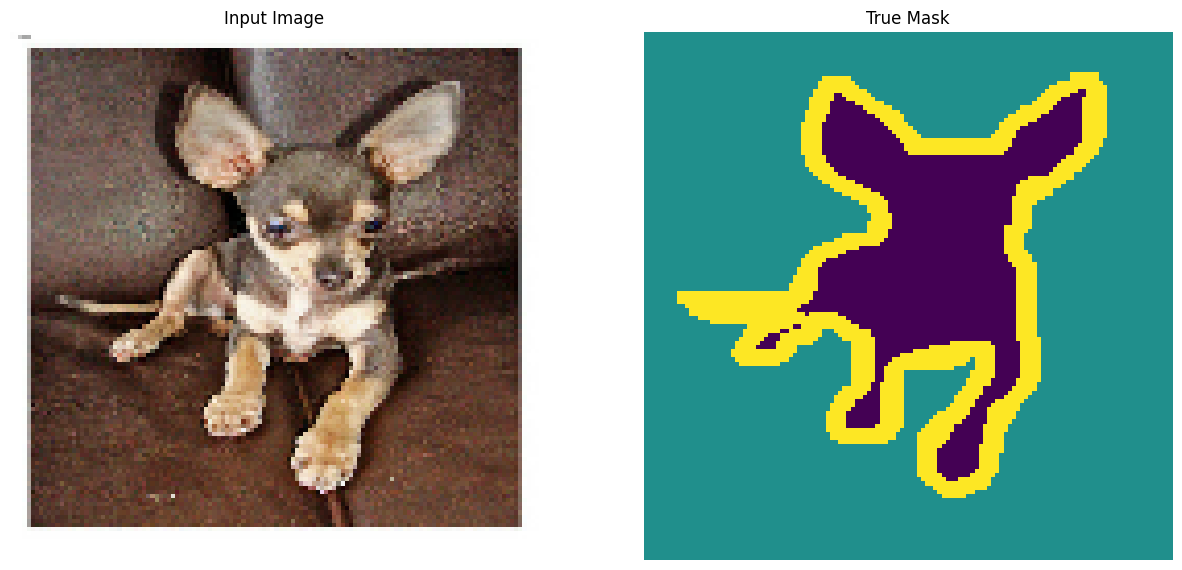

In [ ]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# **Create blocks to build components for U-Net.**

In [ ]:
def double_conv_block(x, n_filters):

    x = layers.Conv2D(n_filters, 3, padding="same", kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPooling2D()(f)
    x = layers.Dropout(0.25)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, strides=2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.25)(x)
    x = double_conv_block(x, n_filters)

    return x

# **Building the U-Net model**

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 2048)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs 3 layers (background, pet, border)
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 72,296,003 (275.79 MB)

 Trainable params: 72,280,131 (275.73 MB)

 Non-trainable params: 15,872 (62.00 KB)

# **Train U-Net**

IoU measures the ratio between the intersection (∩) and the union (∪) of the prediction and the true label.

    Formular: IoU = |A ∩ B| / |A ∪ B|

Because Unet output is 3 layers (background, pet, border), we calculate mean IoU on 3 layers.

    Formular: Mean IoU = (IoU_class_0 + IoU_class_1 + IoU_class_2) / 3

In [ ]:
def mean_iou_coef(y_true, y_pred, num_classes=3, smooth=1):
    y_true_f = tf.cast(tf.squeeze(y_true, axis=-1), tf.float32)
    y_pred_f = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    iou_per_class = []
    for i in range(num_classes):
        true_class = tf.cast(y_true_f == i, tf.float32)
        pred_class = tf.cast(y_pred_f == i, tf.float32)
        intersection = tf.reduce_sum(true_class * pred_class)
        union = tf.reduce_sum(true_class) + tf.reduce_sum(pred_class) - intersection
        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)
    return tf.reduce_mean(iou_per_class)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss="sparse_categorical_crossentropy",
                   metrics=[mean_iou_coef])

In [ ]:
# Create callback to save checkpoint
checkpoint_path = "/content/drive/MyDrive/doan/unet_model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Create Callback to reduce learning rate when loss does not improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce LR to 50% when loss does not improve
    patience=3,  # Patiention for 3 epochs before reducing
    min_lr=1e-6,
    verbose=1
)

# Create a Callback to stop training early if overfitting occurs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,  # Stop if val_loss does not decrease after 7 epochs
    restore_best_weights=True,
    verbose=1
)

In [ ]:
NUM_EPOCHS = 75

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_data=validation_batches,
                               callbacks=[checkpoint_callback, reduce_lr, early_stopping])

Epoch 1/75
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 2.8584 - mean_iou_coef: 0.3174
Epoch 1: val_loss improved from inf to 1.57277, saving model to /content/drive/MyDrive/doan/unet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 197s 999ms/step - loss: 2.8482 - mean_iou_coef: 0.3180 - val_loss: 1.5728 - val_mean_iou_coef: 0.1918 - learning_rate: 0.0010
Epoch 2/75
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 0.9284 - mean_iou_coef: 0.4719
Epoch 2: val_loss improved from 1.57277 to 1.19093, saving model to /content/drive/MyDrive/doan/unet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 93s 807ms/step - loss: 0.9282 - mean_iou_coef: 0.4720 - val_loss: 1.1909 - val_mean_iou_coef: 0.1928 - learning_rate: 0.0010
Epoch 3/75
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 0.8128 - mean_iou_coef: 0.4874
Epoch 3: val_loss did not improve from 1.19093
115/115 ━━━━━━━━━━━━━━━━━━━━ 85s 741ms/step - loss: 0.8125 - mean_iou_coef: 0.4875 - val_loss: 1.2293 - val_mean_iou_coef: 0.2679 - learning_ra

# **Accuracy and loss graph.**

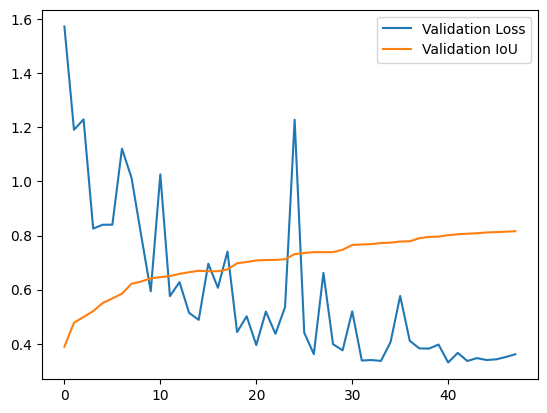

In [ ]:
plt.plot(model_history.history["val_loss"], label="Validation Loss")
plt.plot(model_history.history["mean_iou_coef"], label="Validation IoU")
plt.legend()
plt.show()

## Prediction with U-Net.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 21


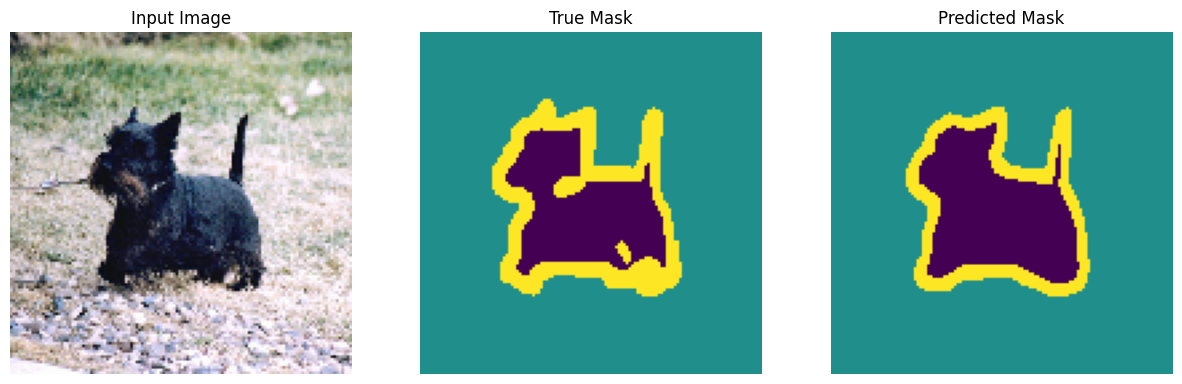

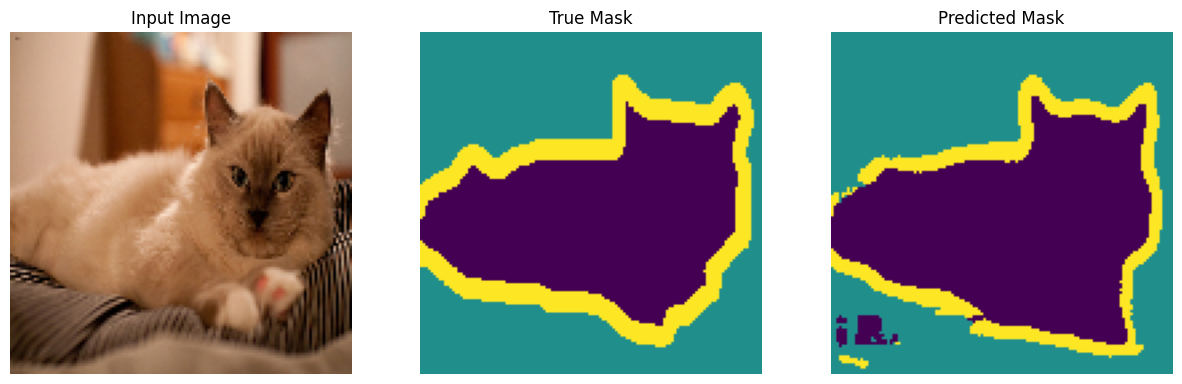

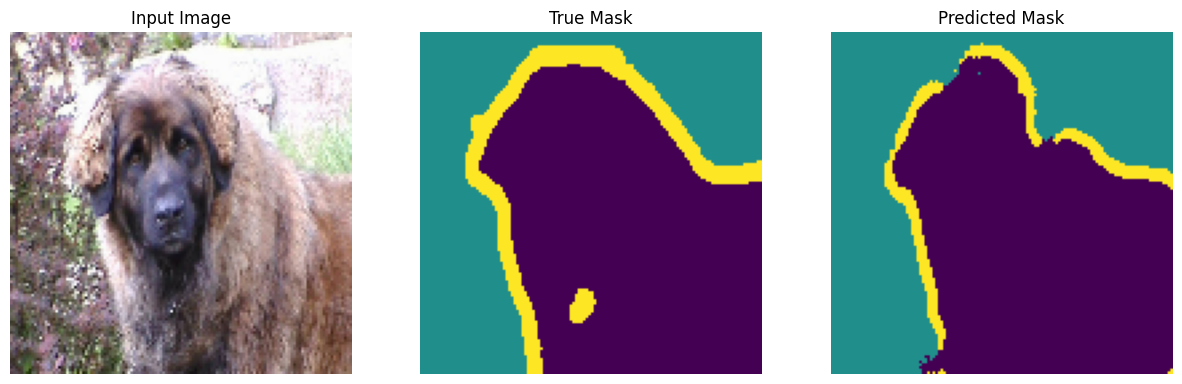

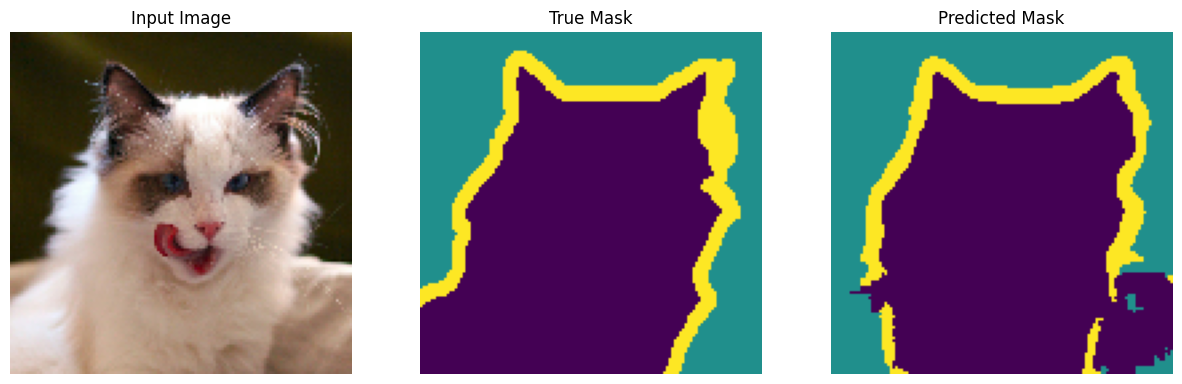

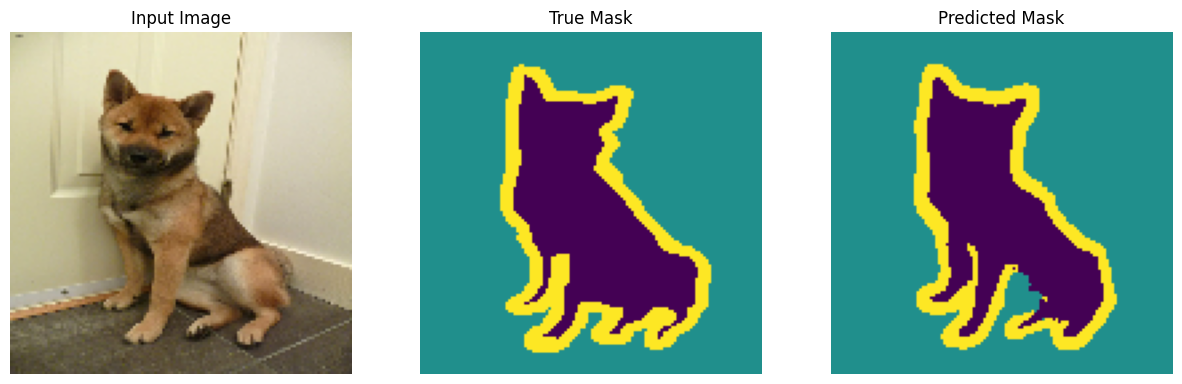

In [ ]:
show_predictions(test_batches.skip(6), 5)

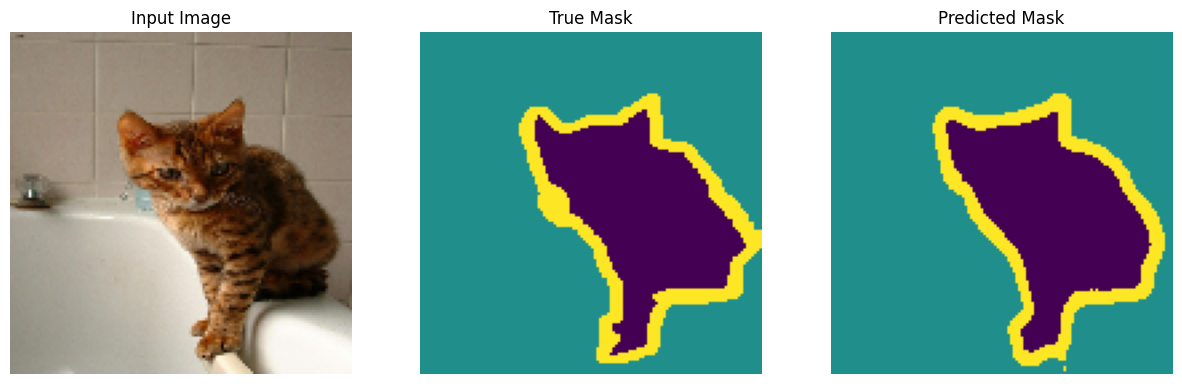

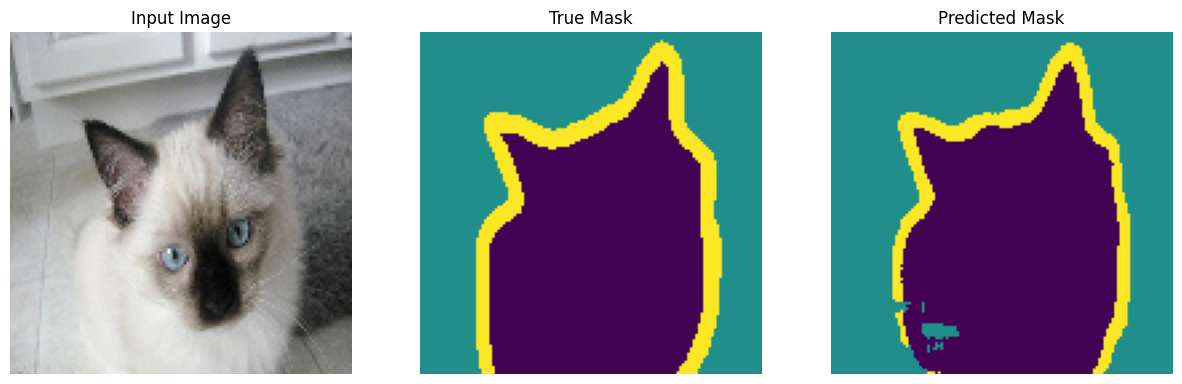

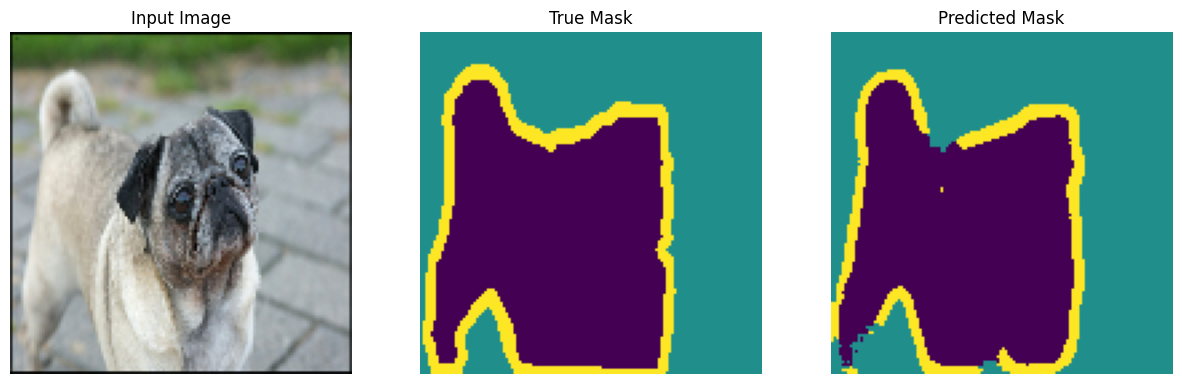

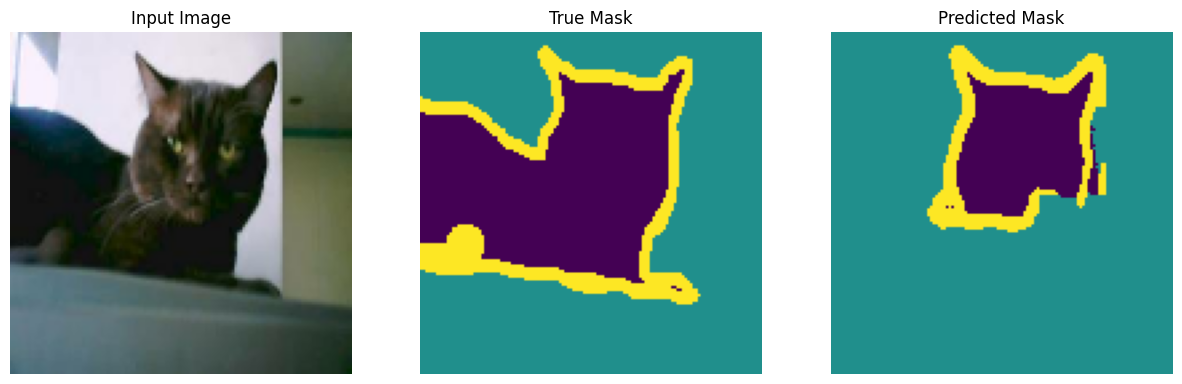

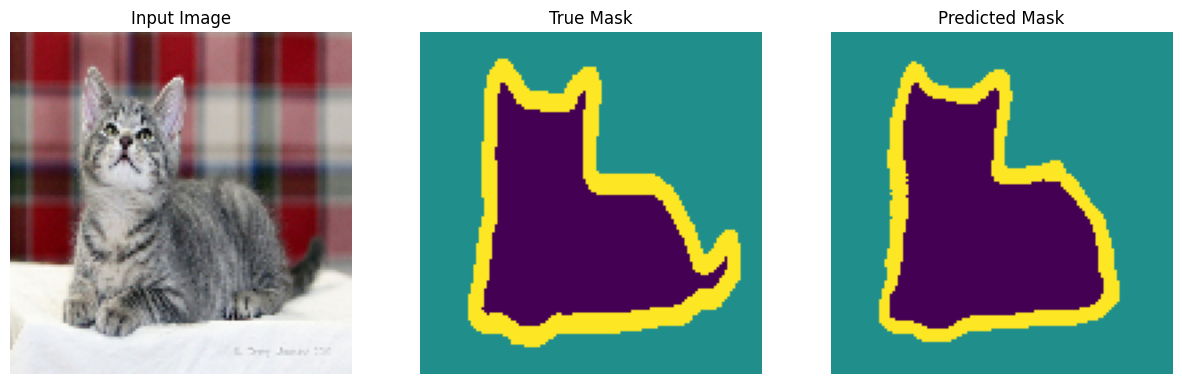

In [ ]:
show_predictions(test_batches.skip(10), 5)